In [1]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau_p and tau_d so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
#
# Only modify code at the bottom! Look for the TODO
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

In [2]:
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

# previous P controller
def run_p(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        # Print some debug messages
        if i < 20:
            print(robot.__repr__())
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        # Print some debug messages
        if i < 20:
            print(robot.__repr__())
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

In [3]:
# P Controller
print("------------ P Controller --------------")
robot_p = Robot()
robot_p.set(0, 1, 0)
x_trajectory_p, y_trajectory_p = run_p(robot_p, 0.2)
n_p = len(x_trajectory_p)

# PD Controller
print("------------ PD Controller -------------")
robot = Robot()
robot.set(0, 1, 0)
x_trajectory, y_trajectory = run(robot, 0.2, 3.0)
n = len(x_trajectory)

------------ P Controller --------------
[x=0.99998 y=0.99493 orient=6.27305]
[x=1.99986 y=0.97976 orient=6.26297]
[x=2.99954 y=0.95458 orient=6.25304]
[x=3.99893 y=0.91961 orient=6.24338]
[x=4.99794 y=0.87517 orient=6.23408]
[x=5.99650 y=0.82166 orient=6.22524]
[x=6.99457 y=0.75961 orient=6.21694]
[x=7.99211 y=0.68960 orient=6.20929]
[x=8.98912 y=0.61231 orient=6.20235]
[x=9.98560 y=0.52849 orient=6.19619]
[x=10.98158 y=0.43897 orient=6.19089]
[x=11.97712 y=0.34462 orient=6.18649]
[x=12.97228 y=0.24635 orient=6.18304]
[x=13.96715 y=0.14515 orient=6.18057]
[x=14.96181 y=0.04199 orient=6.17912]
[x=15.95640 y=-0.06189 orient=6.17870]
[x=16.95095 y=-0.16618 orient=6.17932]
[x=17.94564 y=-0.26903 orient=6.18098]
[x=18.94056 y=-0.36972 orient=6.18367]
[x=19.93580 y=-0.46722 orient=6.18738]
------------ PD Controller -------------
[x=0.99998 y=0.99493 orient=6.27305]
[x=1.99987 y=0.98015 orient=6.26376]
[x=2.99960 y=0.95690 orient=6.25611]
[x=3.99914 y=0.92678 orient=6.25000]
[x=4.99851 y=0.

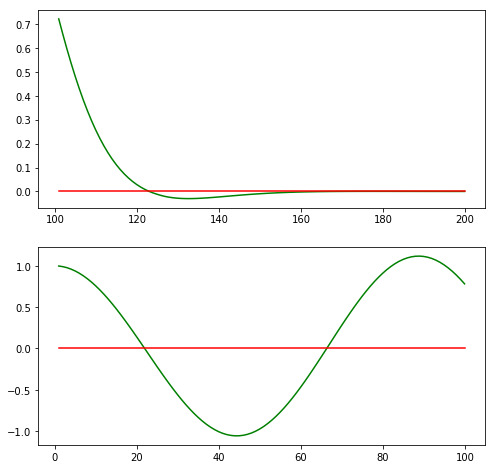

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax2.plot(x_trajectory_p, y_trajectory_p, 'g', label='PD controller')
ax2.plot(x_trajectory_p, np.zeros(n_p), 'r', label='reference')